In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch import nn

torch.__version__

'2.6.0+cu124'

In [3]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03)
len(X), len(y)

(1000, 1000)

In [4]:
X_sample = X[0]
y_sample = y[0]

print(f'X sample: {X_sample}\ny sample: {y_sample}')

X sample: [-0.39546067  0.72689853]
y sample: 1


In [5]:
circles = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'label': y
})

circles.head(10)

,X1,X2,label
0,-0.395461,0.726899,1
1,0.346612,-0.902621,0
2,0.807621,0.015957,1
3,0.146750,-0.759568,1
4,-0.374148,0.680258,1
5,0.521324,-0.600440,1
6,-0.972721,-0.325570,0
7,-0.510712,0.902026,0
8,0.534554,0.819190,0
9,0.045440,-1.028719,0


In [6]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

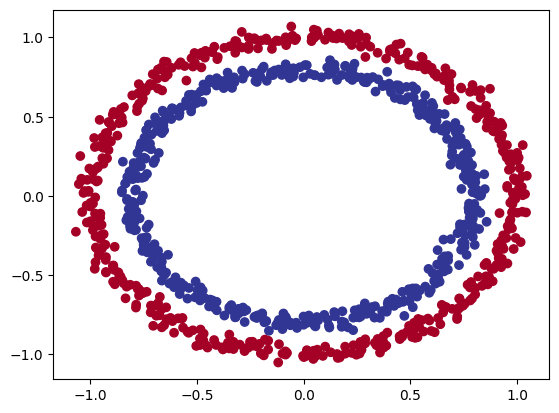

In [7]:
plt.scatter(circles['X1'], circles['X2'], c=y, cmap=plt.cm.RdYlBu)

In [8]:
X = torch.from_numpy(X).type(torch.float64)
y = torch.from_numpy(y).type(torch.float64)

X[:5], y[:5]

(tensor([[-0.3955,  0.7269],
         [ 0.3466, -0.9026],
         [ 0.8076,  0.0160],
         [ 0.1467, -0.7596],
         [-0.3741,  0.6803]], dtype=torch.float64),
 tensor([1., 0., 1., 1., 1.], dtype=torch.float64))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [11]:
X_train = X_train.float().to(device)
X_test = X_test.float().to(device)
y_train = y_train.float().to(device)
y_test = y_test.float().to(device)

X_train.type()


'torch.FloatTensor'

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(in_features=2, out_features=2),
            nn.Linear(in_features=2, out_features=4),
            nn.Linear(in_features=4, out_features=2),
            nn.Linear(in_features=2, out_features=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)


model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Linear(in_features=2, out_features=4, bias=True)
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    params=model0.parameters(),
    lr=0.1
)

In [15]:
untrained_preds = model0(X_test)
print(f'Length of predictions: {len(untrained_preds)} | Shape of predictions: {untrained_preds.shape}')
print(f'Length of test samples: {len(y_test)} | Shape of test samples: {y_test.shape}')
print(f'First 10 untrained predictions: {untrained_preds[:10]}')
print(f'First 10 test samples: {y_test[:10]}')

Length of predictions: 200 | Shape of predictions: torch.Size([200, 1])
Length of test samples: 200 | Shape of test samples: torch.Size([200])
First 10 untrained predictions: tensor([[0.7015],
        [0.6808],
        [0.7012],
        [0.6264],
        [0.6913],
        [0.6540],
        [0.6497],
        [0.6438],
        [0.6509],
        [0.6211]], grad_fn=<SliceBackward0>)
First 10 test samples: tensor([0., 0., 0., 0., 1., 0., 1., 1., 0., 0.])


In [16]:
epochs = 1000

for epoch in tqdm(range(epochs)):
    # Put the model in training mode
    model0.train()
    # forward pass
    train_logits = model0(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))
    # calculate the loss and accuracy
    train_loss = criterion(train_logits, y_train)
    train_acc = accuracy_fn(y_train, train_preds)
    # optimizer zero grad
    optimizer.zero_grad()
    # backpropagation
    train_loss.backward()
    # optimizer step
    optimizer.step()

    # Put the model in testing model
    model0.eval()
    with torch.inference_mode(): # Turn off gradient tracking
        # forward pass
        test_logits = model0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        # calculate the loss and accuracy
        test_loss = criterion(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

        if epoch % 100 == 0:
            print(f'Epoch: {epoch} | Training Loss: {train_loss:.2f}, Training Accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.2f}, Testing Accuracy: {test_acc:.2f}%')
            

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 0.74, Training Accuracy: 50.25% | Testing Loss: 0.75, Testing Accuracy: 49.00%
Epoch: 100 | Training Loss: 0.69, Training Accuracy: 50.12% | Testing Loss: 0.69, Testing Accuracy: 55.50%
Epoch: 200 | Training Loss: 0.69, Training Accuracy: 51.00% | Testing Loss: 0.69, Testing Accuracy: 54.50%
Epoch: 300 | Training Loss: 0.69, Training Accuracy: 51.38% | Testing Loss: 0.69, Testing Accuracy: 52.00%
Epoch: 400 | Training Loss: 0.69, Training Accuracy: 52.12% | Testing Loss: 0.69, Testing Accuracy: 54.50%
Epoch: 500 | Training Loss: 0.69, Training Accuracy: 51.88% | Testing Loss: 0.69, Testing Accuracy: 55.00%
Epoch: 600 | Training Loss: 0.69, Training Accuracy: 51.00% | Testing Loss: 0.69, Testing Accuracy: 53.50%
Epoch: 700 | Training Loss: 0.69, Training Accuracy: 51.88% | Testing Loss: 0.69, Testing Accuracy: 51.50%
Epoch: 800 | Training Loss: 0.69, Training Accuracy: 51.88% | Testing Loss: 0.69, Testing Accuracy: 50.50%
Epoch: 900 | Training Loss: 0.69, Train

In [17]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists. skipping download')
else:
    print('Downloading helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary
    

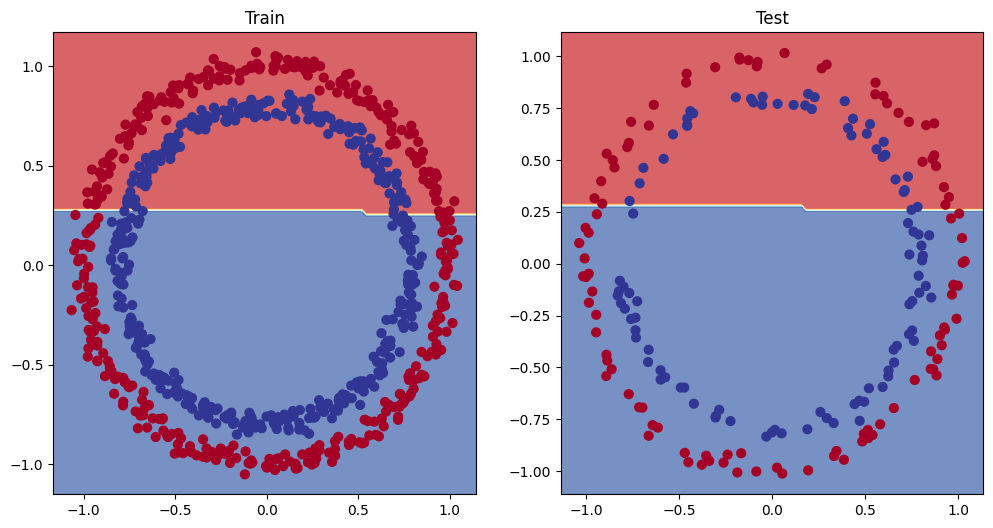

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model0, X_test, y_test)

In [19]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(in_features=2, out_features=4),
            nn.ReLU(),
            nn.Linear(in_features=4, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=4),
            nn.ReLU(),
            nn.Linear(in_features=4, out_features=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)


model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)

In [20]:
optimizer = torch.optim.SGD(
    params=model1.parameters(),
    lr=0.2
)

criterion = torch.nn.BCEWithLogitsLoss()

In [23]:
epochs = 10000

for epoch in tqdm(range(epochs)):
    # Put the model in training mode
    model1.train()
    # forward pass
    train_logits = model1(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))
    # calculate the loss and accuracy
    train_loss = criterion(train_logits, y_train)
    train_acc = accuracy_fn(y_train, train_preds)
    # optimizer zero grad
    optimizer.zero_grad()
    # backpropagation
    train_loss.backward()
    # optimizer step
    optimizer.step()

    # Put the model in testing model
    model1.eval()
    with torch.inference_mode(): # Turn off gradient tracking
        # forward pass
        test_logits = model1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        # calculate the loss and accuracy
        test_loss = criterion(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

        if epoch % 100 == 0:
            print(f'Epoch: {epoch} | Training Loss: {train_loss:.2f}, Training Accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.2f}, Testing Accuracy: {test_acc:.2f}%')
            

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0 | Training Loss: 0.61, Training Accuracy: 63.38% | Testing Loss: 0.62, Testing Accuracy: 61.00%
Epoch: 100 | Training Loss: 0.59, Training Accuracy: 67.50% | Testing Loss: 0.61, Testing Accuracy: 65.00%
Epoch: 200 | Training Loss: 0.56, Training Accuracy: 74.25% | Testing Loss: 0.58, Testing Accuracy: 72.50%
Epoch: 300 | Training Loss: 0.52, Training Accuracy: 74.50% | Testing Loss: 0.55, Testing Accuracy: 70.00%
Epoch: 400 | Training Loss: 0.42, Training Accuracy: 87.62% | Testing Loss: 0.46, Testing Accuracy: 87.50%
Epoch: 500 | Training Loss: 0.50, Training Accuracy: 70.38% | Testing Loss: 0.48, Testing Accuracy: 69.00%
Epoch: 600 | Training Loss: 0.42, Training Accuracy: 74.50% | Testing Loss: 0.42, Testing Accuracy: 73.50%
Epoch: 700 | Training Loss: 0.33, Training Accuracy: 88.00% | Testing Loss: 0.34, Testing Accuracy: 95.50%
Epoch: 800 | Training Loss: 0.42, Training Accuracy: 73.00% | Testing Loss: 0.43, Testing Accuracy: 69.50%
Epoch: 900 | Training Loss: 0.24, Train

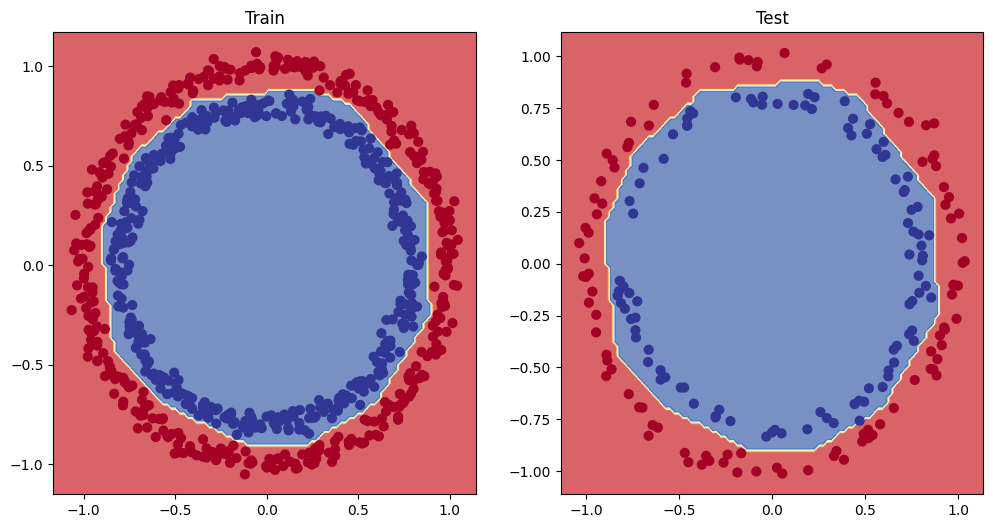

In [24]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model1, X_test, y_test)